In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(factoextra)
library(ggrepel)
library(dplyr)
library(plyr)
library(cowplot)
library(patchwork)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC_H <- color_ND
color_CHC_M <- "#FFCC00"
color_CHC_L <- "#FF3300"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [3]:
setwd("~/ownCloud/Meng/")

In [4]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

In [5]:
colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [6]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

#metadata <- read_excel("100_plus_project/Metadata/2019_07_23_Proteomics_Metadata_forMeng_v3.xlsx",
#                       sheet=1,col_names=TRUE, na="NA")
#metadata <- as.data.frame(metadata)
#colnames(metadata)

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which(metadata$apoe %in% c(22)),]$apoe_OR <- 0.24
metadata[which(metadata$apoe %in% c(23, 32)),]$apoe_OR <- 0.5
metadata[which(metadata$apoe %in% c(33)),]$apoe_OR <- 1.0
metadata[which(metadata$apoe %in% c(24, 42)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe %in% c(34, 43)),]$apoe_OR <- 5.5
metadata[which(metadata$apoe %in% c(44)),]$apoe_OR <- 20.6

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)

[1] 3448  191

In [7]:
summary(metadata)

     nbb              autopsy              sex                 age       
 Length:190         Length:190         Length:190         Min.   : 50.0  
 Class :character   Class :character   Class :character   1st Qu.: 78.0  
 Mode  :character   Mode  :character   Mode  :character   Median : 89.0  
                                                          Mean   : 86.8  
                                                          3rd Qu.:100.0  
                                                          Max.   :111.0  
    weight             GROUP               pmd                braak      
 Length:190         Length:190         Length:190         Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :4.000  
                                                          Mean   :3.611  
                                                          3rd Qu.:5.000  
                                      

In [8]:
table(metadata$GROUP)


 AD CHC  ND 
 88  49  53 

In [9]:
#save(metadata, file = "100_plus_project/Metadata/metadata_clean_update20220901.Rdata")

In [10]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [11]:
save(protein_intensity_combat, file = "R_workstation/100_plus_proteomic_DATA/protein_intensity_combat.Rdata")

In [10]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype_v2.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [11]:
dim(cell_type_matrix)

[1] 3448    4

In [12]:
cell_type_matrix[grep(";", cell_type_matrix$protein), ]$celltype <- NA

In [10]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    #print(sort(unique(braak)))
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}

get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

In [11]:
get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

In [12]:
table(metadata$GROUP)


 AD CHC  ND 
 88  49  53 

In [13]:
Braak_test_index <- which((metadata$GROUP != "CHC"))
length(Braak_test_index)

protein_intensity_combat_nonlog <- 2^protein_intensity_combat

[1] 141

In [14]:
pathology_related_proteins_ANOVA <- as.data.frame(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                        cal_ANOVA_test, metadata[Braak_test_index, ]$fBraak))
colnames(pathology_related_proteins_ANOVA) <- c("p_value")
pathology_related_proteins_ANOVA$adjusted_p_value <- p.adjust(pathology_related_proteins_ANOVA$p_value,
                                                              method="BH")

pathology_related_proteins_ANOVA$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
pathology_related_proteins_ANOVA$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)


pathology_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                       lm_sig_test, metadata[Braak_test_index,]$fBraak)))
colnames(pathology_related_proteins_lm) <- c("effect_size", "p_value")
pathology_related_proteins_lm$adjusted_p_value <- p.adjust(pathology_related_proteins_lm$p_value, 
                                                              method="BH")

#pathology_related_proteins_lm$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
#                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
pathology_related_proteins_lm$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)

In [15]:
## Save file for some other analysis

In [16]:
test_result <- cbind(pathology_related_proteins_ANOVA[, 1:3], pathology_related_proteins_lm[, 1:3])

colnames(test_result) <- c("p_value_ANOVA", "adj.p_value_ANOVA", "effect_size_ANOVA", 
                           "effect_size_lm", "p_value_lm", "adj.p_value_lm")

In [17]:
test_result$protein <- rownames(test_result)

In [18]:
test_result$gene <- get_first_protein(test_result$protein)

In [19]:
write.table(test_result[, c(8,1,2,3,4,5,6,7)], 
            "100_plus_results/sig_protein_list/Braak_stage_related_proteins_test_results.tsv",
            row.names = FALSE, quote = FALSE, sep = "\t")

In [20]:
top_percent_p <- 0.05
top_percent_lfc <- 0.05

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)
top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]
topT_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(topT_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)
top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]
topT_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(topT_up_ANOVA)

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)
top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]
topT_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(topT_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)
top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]
topT_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(topT_up_lm)

topT_down_union <- union(topT_down_ANOVA, topT_down_lm)
topT_up_union <- union(topT_up_ANOVA, topT_up_lm)
length(topT_down_union)
length(topT_up_union)

topT_sig_index <- union(topT_down_union,topT_up_union)
length(topT_sig_index)

[1] 13

[1] 28

[1] 30

[1] 37

[1] 30

[1] 40

[1] 70

In [21]:
#old_down_regulation_protein <- read.table("R_workstation/100_plus_proteomic_data_Analysis/Pathology_related_down_regulation_proteins.txt", 
#                                          stringsAsFactors = FALSE, header = FALSE)
#
#setdiff(rownames(pathology_related_proteins_ANOVA)[topT_down_union], old_down_regulation_protein$V1)
#
#setdiff(old_down_regulation_protein$V1, rownames(pathology_related_proteins_ANOVA)[topT_down_union])

In [22]:
#old_up_regulation_protein <- read.table("R_workstation/100_plus_proteomic_data_Analysis/Pathology_related_up_regulation_proteins.txt", 
#                                          stringsAsFactors = FALSE, header = FALSE)
#
#setdiff(rownames(pathology_related_proteins_ANOVA)[topT_up_union], old_up_regulation_protein$V1)
#
#setdiff(old_up_regulation_protein$V1, rownames(pathology_related_proteins_ANOVA)[topT_up_union])

In [23]:
top_percent_p <- 0.20
top_percent_lfc <- 0.20

## Top down-regulating proteins ##
## Top down-regulating proteins ##

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)

top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]

top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)

top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]

top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)



#plot_selected_protein_lfc(pathology_related_proteins_ANOVA, c(top_up_ANOVA, top_down_ANOVA))

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)
top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]
top_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(top_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)
top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]
top_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(top_up_lm)

#plot_selected_protein_es(pathology_related_proteins_lm, c(top_down_lm, top_up_lm))

top_down_union <- union(top_down_ANOVA, top_down_lm)
top_up_union <- union(top_up_ANOVA, top_up_lm)
length(top_down_union)
length(top_up_union)

sig_index <- c(top_down_union,top_up_union)
length(sig_index)

[1] 140

[1] 190

[1] 206

[1] 235

[1] 226

[1] 246

[1] 472

In [24]:
length(union(top_down_ANOVA, top_up_ANOVA))

[1] 330

In [25]:
length(union(top_down_lm, top_up_lm))

[1] 441

In [26]:
save(sig_index, file = "Temp_results/Braak_stage_related_proteins_sig_index.Rdata")

### Prepare data table for proteomics paper 

In [78]:
pathology_related_proteins_ANOVA <- cbind(rownames(pathology_related_proteins_ANOVA), 
                                          pathology_related_proteins_ANOVA)

colnames(pathology_related_proteins_ANOVA) <- c("Protein_name", "ANOVA_p_value", "ANOVA_FDR", 
                                                "LFC", "Gene")

pathology_related_proteins_ANOVA$ANOVA_top20_p <- "no"
pathology_related_proteins_ANOVA[c(top_down_ANOVA_p, top_up_ANOVA_p), ]$ANOVA_top20_p <- "yes"

pathology_related_proteins_ANOVA$ANOVA_top20_LFC <- "no"
pathology_related_proteins_ANOVA[c(top_down_ANOVA_lfc, top_up_ANOVA_lfc), ]$ANOVA_top20_LFC <- "yes"

pathology_related_proteins_ANOVA$Significant_in_assumption1 <- "no"
pathology_related_proteins_ANOVA[c(top_down_ANOVA, top_up_ANOVA), ]$Significant_in_assumption1 <- "yes"

In [79]:
pathology_related_proteins_lm <- cbind(rownames(pathology_related_proteins_lm), 
                                       pathology_related_proteins_lm)

colnames(pathology_related_proteins_lm) <- c("Protein name", "Linear_effect_size", "Linear_p_value", 
                                             "Linear_FDR", "Gene")

pathology_related_proteins_lm$Linear_top20_p <- "no"
pathology_related_proteins_lm[c(top_down_lm_p, top_up_lm_p), ]$Linear_top20_p <- "yes"

pathology_related_proteins_lm$Linear_top20_effect_size <- "no"
pathology_related_proteins_lm[c(top_down_lm_lfc, top_up_lm_lfc), ]$Linear_top20_effect_size <- "yes"

pathology_related_proteins_lm$Significant_in_assumption2 <- "no"
pathology_related_proteins_lm[c(top_down_lm, top_up_lm), ]$Significant_in_assumption2 <- "yes"

In [80]:
Braak_stage_related_proteins <- cbind(pathology_related_proteins_ANOVA, pathology_related_proteins_lm)

In [71]:
write.table(Braak_stage_related_proteins[sig_index, ], 
            file = "100_plus_results/Results_for_paper_supplementary/Braak_stage_related_proteins_two_assumptions.tsv",
            row.names = FALSE, quote = FALSE, sep = "\t")

#### Prepare data table for proteomics paper

### The rank sum of four criteria

In [81]:
Braak_stage_related_proteins

,Protein_name,ANOVA_p_value,ANOVA_FDR,LFC,Gene,ANOVA_top20_p,ANOVA_top20_LFC,Significant_in_assumption1,Protein name,Linear_effect_size,Linear_p_value,Linear_FDR,Gene,Linear_top20_p,Linear_top20_effect_size,Significant_in_assumption2
,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
SLC12A2,SLC12A2,4.784744e-06,1.775866e-05,-0.5010123,SLC12A2,no,yes,no,SLC12A2,-0.040405950,4.288788e-03,7.270277e-03,SLC12A2,no,no,no
CASKIN1,CASKIN1,3.981658e-14,1.430079e-12,-0.5876160,CASKIN1,yes,yes,yes,CASKIN1,-0.101233819,1.069147e-21,2.972919e-20,CASKIN1,yes,yes,yes
GNG2,GNG2,8.612903e-02,1.220086e-01,0.4775213,GNG2,no,no,no,GNG2,-0.022004161,2.459912e-01,2.968770e-01,GNG2,no,no,no
CARNS1,CARNS1,5.588763e-06,2.032706e-05,1.6271891,CARNS1,no,yes,no,CARNS1,0.049453559,1.934021e-01,2.391860e-01,CARNS1,no,no,no
FH,FH,5.053379e-04,1.216717e-03,0.4652301,FH,no,no,no,FH,0.072254696,1.031492e-08,3.775568e-08,FH,no,no,no
EFHD2,EFHD2,2.103770e-04,5.444724e-04,0.8650315,EFHD2,no,yes,no,EFHD2,0.155067004,2.208382e-08,7.738316e-08,EFHD2,no,yes,no
PCLO,PCLO,1.106047e-01,1.513954e-01,-0.7182641,PCLO,no,yes,no,PCLO,-0.069177206,1.683291e-02,2.596863e-02,PCLO,no,no,no
HSPA1A;HSPA1B,HSPA1A;HSPA1B,2.644252e-09,2.145266e-08,0.7024685,HSPA1A,yes,no,no,HSPA1A;HSPA1B,0.119603914,2.652987e-16,2.978453e-15,HSPA1A,yes,no,no
STIP1,STIP1,2.347769e-08,1.530266e-07,1.6115302,STIP1,yes,yes,yes,STIP1,0.281726168,8.287425e-17,1.009719e-15,STIP1,yes,yes,yes


In [82]:
Braak_stage_related_proteins$ANOVA_p_rank <- 0
Braak_stage_related_proteins$ANOVA_LFC_rank <- 0
Braak_stage_related_proteins$Linear_p_rank <- 0
Braak_stage_related_proteins$Linear_beta_rank <- 0

In [83]:
Braak_stage_related_proteins[order(Braak_stage_related_proteins$ANOVA_p_value), ]$ANOVA_p_rank <- 1:nrow(Braak_stage_related_proteins)
Braak_stage_related_proteins[order(abs(Braak_stage_related_proteins$LFC), decreasing = TRUE), ]$ANOVA_LFC_rank <- 1:nrow(Braak_stage_related_proteins)
Braak_stage_related_proteins[order(Braak_stage_related_proteins$Linear_p_value), ]$Linear_p_rank <- 1:nrow(Braak_stage_related_proteins)
Braak_stage_related_proteins[order(abs(Braak_stage_related_proteins$Linear_effect_size), decreasing = TRUE), ]$Linear_beta_rank <- 1:nrow(Braak_stage_related_proteins)


In [84]:
Braak_stage_related_proteins$rank_sum <- rowSums(Braak_stage_related_proteins[,c("ANOVA_p_rank",
                                                                                 "ANOVA_LFC_rank",
                                                                                 "Linear_p_rank",
                                                                                 "Linear_beta_rank")])

In [85]:
Braak_stage_related_proteins[order(Braak_stage_related_proteins$rank_sum), ]

,Protein_name,ANOVA_p_value,ANOVA_FDR,LFC,Gene,ANOVA_top20_p,ANOVA_top20_LFC,Significant_in_assumption1,Protein name,Linear_effect_size,⋯,Linear_FDR,Gene,Linear_top20_p,Linear_top20_effect_size,Significant_in_assumption2,ANOVA_p_rank,ANOVA_LFC_rank,Linear_p_rank,Linear_beta_rank,rank_sum
,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAPT,MAPT,1.459093e-23,5.030952e-20,2.201695,MAPT,yes,yes,yes,MAPT,0.4667545,⋯,7.705531e-36,MAPT,yes,yes,yes,1,17,2,5,25
ICAM1,ICAM1,9.859220e-20,3.399459e-17,2.534495,ICAM1,yes,yes,yes,ICAM1,0.5177976,⋯,2.926075e-28,ICAM1,yes,yes,yes,10,7,10,3,30
VGF,VGF,6.463818e-21,4.457449e-18,-2.291521,VGF,yes,yes,yes,VGF,-0.4060557,⋯,8.568118e-26,VGF,yes,yes,yes,5,15,26,11,57
CD44,CD44,7.461613e-16,5.473966e-14,3.328352,CD44,yes,yes,yes,CD44,0.6863633,⋯,3.735004e-26,CD44,yes,yes,yes,47,2,20,1,70
HSPB1,HSPB1,4.972092e-18,8.571887e-16,1.680005,HSPB1,yes,yes,yes,HSPB1,0.3076900,⋯,1.333494e-31,HSPB1,yes,yes,yes,20,44,5,33,102
HTRA1,HTRA1,3.464701e-18,6.287521e-16,1.672169,HTRA1,yes,yes,yes,HTRA1,0.3119878,⋯,3.189277e-28,HTRA1,yes,yes,yes,19,47,11,31,108
RPH3A,RPH3A,1.917868e-21,2.204269e-18,-1.551709,RPH3A,yes,yes,yes,RPH3A,-0.2980680,⋯,1.008091e-31,RPH3A,yes,yes,yes,3,67,4,40,114
TARS,TARS,1.135673e-17,1.702522e-15,1.773843,TARS,yes,yes,yes,TARS,0.3211497,⋯,1.376582e-25,TARS,yes,yes,yes,23,35,33,29,120
GFAP,GFAP,8.411834e-15,3.580741e-13,2.699544,GFAP,yes,yes,yes,GFAP,0.4944824,⋯,1.605581e-25,GFAP,yes,yes,yes,81,6,34,4,125


In [89]:
protein_for_plot <- Braak_stage_related_proteins[order(Braak_stage_related_proteins$rank_sum)[1:16], ]$Protein_name %>% as.character()

In [90]:
protein_for_plot

[1] "MAPT"                 "ICAM1"                "VGF"                 
 [4] "CD44"                 "HSPB1"                "HTRA1"               
 [7] "RPH3A"                "TARS"                 "GFAP"                
[10] "PLCD1"                "EZR"                  "RPS27A;UBA52;UBB;UBC"
[13] "CSRP1"                "BBOX1"                "APP"                 
[16] "GPRASP1"

In [60]:
load(file = "Temp_results/Braak_stage_related_proteins_inAD_1204.Rdata")

In [61]:
length(Braak_AD_index)
length(sig_index)
length(intersect(sig_index, Braak_AD_index))

[1] 1204

[1] 472

In [69]:
x <- list(sig_inAD=Braak_AD_index, 
          B_protein=sig_index)

path <- "100_plus_plots/proteomics/Overlap_1204_and_472_proteins.tiff"
p <- venn.diagram(x, filename = path, imagetype = "tiff", 
                  fill=c('slateblue', 'sienna1'),
                  category.names=c("Proteins correlated with \n AD-associated increase of Braak stages",
                                   "B-proteins"), margin = 0.01,
                  lwd = 0, alpha = 0.8, cat.dist=c(-0.1, -0.04))
#grid.draw(p)

In [25]:
pathology_related_proteins_ANOVA[c(top_down_ANOVA, top_up_ANOVA)
                                 [order(pathology_related_proteins_ANOVA[c(top_down_ANOVA, top_up_ANOVA),]$p_value)], ]
                                                                   

,p_value,adjusted_p_value,effect_size,Gene
,<dbl>,<dbl>,<dbl>,<chr>
MAPT,1.459093e-23,5.030952e-20,2.2016950,MAPT
SYT12,5.836626e-23,1.006234e-19,-1.1722376,SYT12
RPH3A,1.917868e-21,2.204269e-18,-1.5517087,RPH3A
VGF,6.463818e-21,4.457449e-18,-2.2915211,VGF
RPS27A;UBA52;UBB;UBC,3.062496e-20,1.587204e-17,1.3840872,RPS27A
NDUFS3,3.222281e-20,1.587204e-17,-0.5922395,NDUFS3
PDK3,4.040558e-20,1.741481e-17,-0.8372619,PDK3
CNN3,5.331454e-20,2.042539e-17,1.2128839,CNN3
ICAM1,9.859220e-20,3.399459e-17,2.5344953,ICAM1


In [26]:
pathology_related_proteins_lm[c(top_down_lm, top_up_lm)
                              [order(pathology_related_proteins_lm[c(top_down_lm, top_up_lm),]$p_value)], ]


,effect_size,p_value,adjusted_p_value,Gene
,<dbl>,<dbl>,<dbl>,<chr>
SYT12,-0.23924445,6.009909e-43,2.072217e-39,SYT12
MAPT,0.46675451,4.469565e-39,7.705531e-36,MAPT
RPS27A;UBA52;UBB;UBC,0.28172668,5.015812e-35,5.764840e-32,RPS27A
RPH3A,-0.29806800,1.169479e-34,1.008091e-31,RPH3A
HSPB1,0.30769000,1.933721e-34,1.333494e-31,HSPB1
SLC25A11,-0.09835495,5.587740e-34,3.211088e-31,SLC25A11
GRIA3,-0.14447697,3.018339e-33,1.486748e-30,GRIA3
DLAT,-0.09102255,2.604408e-32,1.122500e-29,DLAT
NDUFS3,-0.11366440,3.815273e-31,1.461673e-28,NDUFS3


In [34]:
write.table(test_result[, c(7, 8, 1, 2, 3, 4, 5, 6)], 
            "100_plus_results/sig_protein_list/ANOVA_lm_test_results.tsv",
            row.names = FALSE, quote = FALSE, sep = "\t")

In [52]:
write.table(sig_index, 
            "100_plus_results/sig_protein_list/Braak_stage_related_proteins_union.txt",
            row.names = FALSE, quote = FALSE, sep = "\t")
write.table(union(top_down_ANOVA, top_up_ANOVA), 
            "100_plus_results/sig_protein_list/Braak_stage_related_proteins_ANOVA.txt",
            row.names = FALSE, quote = FALSE, sep = "\t")
write.table(union(top_down_lm, top_up_lm), 
            "100_plus_results/sig_protein_list/Braak_stage_related_proteins_lm.txt",
            row.names = FALSE, quote = FALSE, sep = "\t")

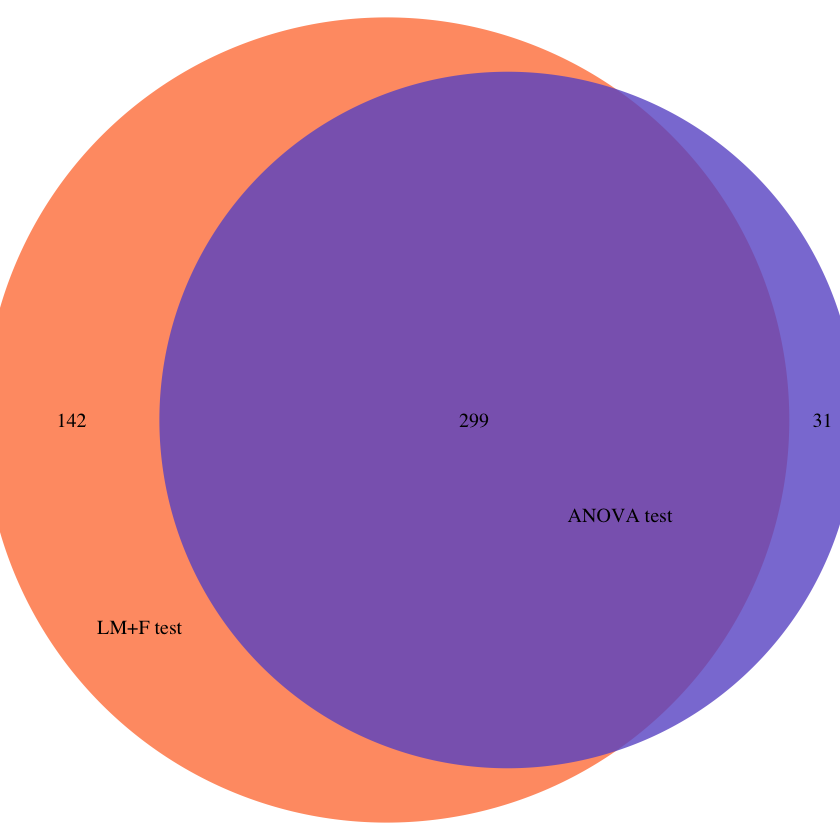

In [32]:
x <- list(ANOVA_sig=union(top_down_ANOVA, top_up_ANOVA), 
          lm=union(top_down_lm, top_up_lm))

path <- "Temp_results/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = NULL, #imagetype = "png", 
                  fill=c('slateblue', 'sienna1'),
                  category.names=c("ANOVA test","LM+F test"), margin = -0.01,
                  lwd = 0, alpha = 0.8, cat.dist=c(-0.1, -0.04))
grid.draw(p)

In [33]:
label_idx <- union(c(topT_down_ANOVA, topT_up_ANOVA), c(topT_down_lm, topT_up_lm))

In [34]:
labeled_proteins <- rownames(pathology_related_proteins_ANOVA[label_idx, ])

In [35]:
multiple_names_proteins <- labeled_proteins[grep(";", labeled_proteins)]

In [36]:
multiple_names_proteins <- data.frame(protein = sort(multiple_names_proteins), stringsAsFactors = FALSE)

In [37]:
multiple_names_proteins$label <- sapply(multiple_names_proteins$protein, function(x){
    label <- paste(unlist(str_split(x, ";"))[1], "1", sep="")
    return(label)
})

In [38]:
multiple_names_proteins

protein,label
<chr>,<chr>
ACTN1;ACTN2;ACTN3,ACTN11
ACTN2;ACTN3,ACTN21
AKR7A2;AKR7L,AKR7A21
EZR;MSN;RDX,EZR1
FBH1;FBXO18,FBH11
PRDX1;PRDX4,PRDX11
PRPH;VIM,PRPH1
RPS27A;UBA52;UBB;UBC,RPS27A1
SLC25A4;SLC25A6,SLC25A41


In [39]:
for(i in 1:nrow(multiple_names_proteins)){
    cat(multiple_names_proteins[i,]$label, end=":", sep="")
    cat(multiple_names_proteins[i,]$protein, end=", ", sep="")
}

ACTN11:ACTN1;ACTN2;ACTN3, ACTN21:ACTN2;ACTN3, AKR7A21:AKR7A2;AKR7L, EZR1:EZR;MSN;RDX, FBH11:FBH1;FBXO18, PRDX11:PRDX1;PRDX4, PRPH1:PRPH;VIM, RPS27A1:RPS27A;UBA52;UBB;UBC, SLC25A41:SLC25A4;SLC25A6, SLC25A51:SLC25A5;SLC25A6, 

In [64]:
table(cell_type_matrix$celltype, useNA = "ifany")


      Astrocytes      Endothelial        ExNeurons        InNeurons 
              61                5               56               19 
       Microglia              OPC Oligodendrocytes          Unknown 
              24               17               61               10 
            <NA> 
            3195 

In [65]:
#cell_type_matrix$CELL <- NA
#cell_type_matrix[which(cell_type_matrix$celltype %in% c("ExNeurons", "InNeurons")), ]$CELL <- "Neurons"
#cell_type_matrix[which(cell_type_matrix$celltype %in% c("Astrocytes")), ]$CELL <- "Astrocytes"
#cell_type_matrix[which(cell_type_matrix$celltype %in% c("Oligodendrocytes")), ]$CELL <- "Oligodendrocytes"

In [66]:
#cell_type_matrix$O_celltype <- cell_type_matrix$celltype
#cell_type_matrix$celltype <- cell_type_matrix$CELL

In [77]:
## Define color of cells
## Define color of cells
## Define color of cells
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
ExNeurons = "#ADDD8E"
InNeurons = "#339900"
OPC = "#A50F15"
Oligodendrocytes = "#DD3497"
Unknown = "#008080"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [78]:
generate_data_matrix_for_plot <- function(data, sig_index){
    data$gene <- cell_type_matrix$protein
    data$celltype <- cell_type_matrix$celltype
    data[which(data$celltype == "Unknown"), ]$celltype <- NA
    sig_DE_ns_celltype <- sig_index[which(is.na(cell_type_matrix[sig_index, ]$celltype))]
    data[sig_DE_ns_celltype,]$celltype <- "NS_celltype"
    
    #print(data[sig_DE_ns_celltype,])
    data[-sig_index,]$celltype <- "NS_at_all"

    data$alpha <- 1
    data[-sig_index,]$alpha <- 0.2
    
    return(data)
}

In [79]:
#plot_volcano_with_cell_enrich <- function(data, sig_index, label_index, xlab){
#    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
#    
#    labels <- rep('', nrow(data_matrix))
#    labels[label_index] <- data_matrix[label_index,]$gene
#    
#    multiple_names_idx <- grep(";", labels)
#    labels[multiple_names_idx] <- sapply(labels[multiple_names_idx], function(x){
#                                            return(paste(unlist(str_split(x, ";"))[1], "[1]", sep=""))
#    })
#    
#    data_matrix$celltype <- factor(data_matrix$celltype, levels=c("Astro", "Endo", "MG/MF", "Neurons", 
#                                                            "Oligo", "NS_celltype", "NS_at_all"))
#    
#    p <- ggplot(data=data_matrix, 
#        aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype)) +
#    
#        #geom_point(data=data_matrix[-sig_index, ],
#        #           aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype), 
#        #          size = 2, alpha = data_matrix[-sig_index, ]$alpha) +
#        
#        geom_point(size = 2, alpha = data_matrix$alpha) +
#  
#        geom_text_repel(aes(label=labels), size=3, show.legend = FALSE, parse=TRUE) +
#        xlab(xlab) + ylab("-log10(P value) FDR") +
#    
#    
#        scale_color_manual(name="Cell type", values = c(Astrocytes, Endothelial, Microglia, Neurons, 
#                                             Oligodendrocytes, No_unique_enrichment, NS_DEPs),
#                           labels = c(paste("Astrocytes (n=", length(which(data_matrix$celltype == "Astro")), ")", sep = ''), 
#                                  paste("Endothelial cell (n=", length(which(data_matrix$celltype == "Endo")), ")", sep = ''),
#                                  paste("Microglia/macrophages (n=", length(which(data_matrix$celltype == "MG/MF")), ")", sep = ''),
#                                  paste("Neurons (n=", length(which(data_matrix$celltype == "Neurons")), ")", sep = ''),
#                                  paste("Oligodendrocytes (n=", length(which(data_matrix$celltype == "Oligo")), ")", sep = ''),
#                                  paste("No unique enrichment (n=", length(which(data_matrix$celltype == "NS_celltype")), ")", sep = ''),
#                                  paste("NS DEPS (n=", length(which(data_matrix$celltype == "NS_at_all")), ")", sep = ''))
#                      )+
#    
#    
#        theme(panel.border = element_blank(),
#          panel.grid.major = element_blank(),
#          panel.grid.minor = element_blank(),
#          panel.background = element_blank(),
#          
#          legend.position = "right",
#          legend.direction = "vertical",
#          
#          legend.text = element_text(size = 8, color = "black", face = "bold"),
#          
#          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
#                                     vjust = 0.5, hjust = 0.5),
#          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
#          axis.line = element_line(size = 0.5, linetype = "solid",
#                                   colour = "gray")
#          #legend.position = "none")
#              )
#    return(p)
#    
#}

In [80]:
#pdf("Temp_results/volcano_plot_union_results.pdf")
#plot_volcano_with_cell_enrich(pathology_related_proteins_ANOVA, 
#                              sig_index, topT_sig_index, "Fold Change (log2)")
#dev.off()

In [81]:
#table(cell_type_matrix$celltype)

In [100]:
plot_volcano_with_cell_enrich_v2 <- function(data, sig_index, label_index, xlab, x_breaks, x_labels){
    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
    
    labels <- rep(NA, nrow(data_matrix))
    labels[label_index] <- data_matrix[label_index,]$gene
    
    multiple_names_idx <- grep(";", labels)
    labels[multiple_names_idx] <- sapply(labels[multiple_names_idx], function(x){
                                            return(paste(unlist(str_split(x, ";"))[1], "[1]", sep=""))
    })
    data_matrix$labels <- labels
    
    #print(labels)
    
    #print(table(data_matrix$celltype))
    
    data_matrix$celltype <- factor(data_matrix$celltype, 
                                   levels=c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "OPC", "Oligodendrocytes", "Unknown", 
                                            "NS_celltype", "NS_at_all"))
    
    p <- ggplot(data=data_matrix, 
        aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype, label = labels)) +
    
        #geom_point(data=data_matrix[-sig_index, ],
        #           aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype), 
        #          size = 2, alpha = data_matrix[-sig_index, ]$alpha) +
        
        geom_point(size = 2, alpha = data_matrix$alpha) +
  
        geom_text_repel(size=4, show.legend = FALSE, parse=TRUE, na.rm=TRUE) +
        xlab(xlab) + ylab("-log10(FDR)") +
    
        scale_x_continuous(breaks=x_breaks, labels = x_labels) +
    
    
        scale_color_manual(name="Cell type", 
                           breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "OPC", "Oligodendrocytes", "Unknown", 
                                            "NS_celltype", "NS_at_all"),
                           values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                                        Microglia, OPC, Oligodendrocytes, Unknown, 
                                                        No_unique_enrichment, NS_DEPs),
                           labels = c("Astrocytes", 
                                      "Endothelial cell", 
                                      "ExNeurons",
                                      "InNeurons",
                                      "Microglia",
                                      "OPC", 
                                      "Oligodendrocytes", 
                                      "Unknown",
                                      "Not marker", 
                                      "NS DEPS")
                      )+
        guides(color=guide_legend(ncol=2)) +
        #guides(color=FALSE) +
    
        theme(panel.border = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank(),
              
              legend.position = "right",
              legend.direction = "vertical",
              legend.title = element_text(size = 16, color = "black", face = "bold"),
              legend.text = element_text(size = 12, color = "black", face = "bold"),
              axis.title = element_text(size = 12, color = "black", face = "bold"),
              axis.text.x = element_text(size = 10, color = "black", face = "bold", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line = element_line(size = 0.5, linetype = "solid",
                                       colour = "gray")
              #legend.position = "none")
              )
    return(p)
    
}

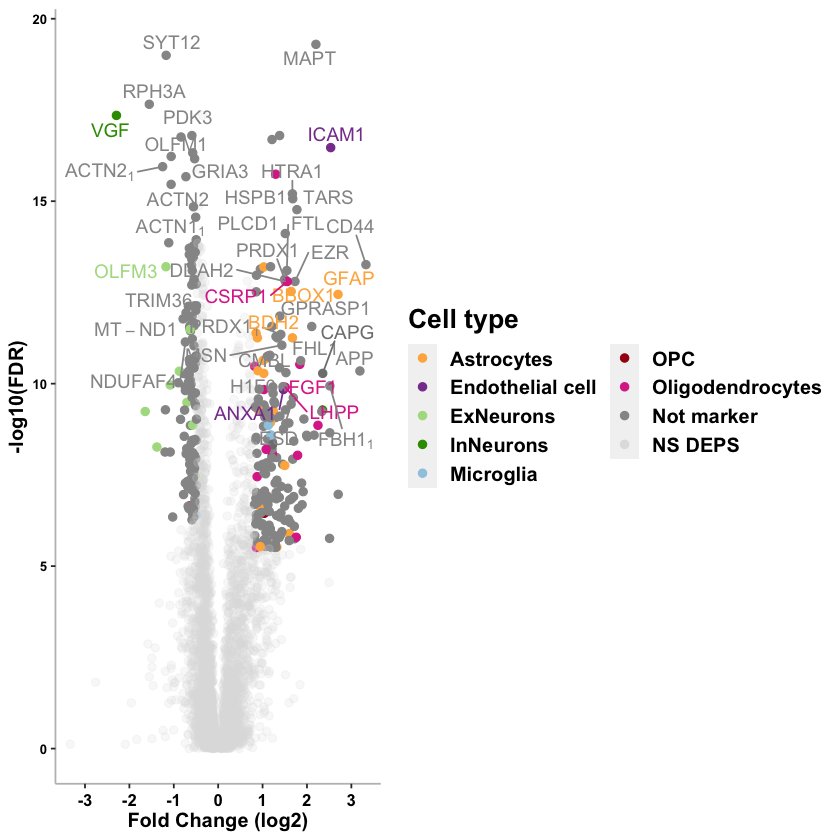

In [101]:
#jpeg("Temp_results/volcano_plot_for_ANOVA_test.jpg")
p1 <- plot_volcano_with_cell_enrich_v2(pathology_related_proteins_ANOVA, 
                              c(top_down_ANOVA, top_up_ANOVA), 
                              c(topT_down_ANOVA, topT_up_ANOVA), "Fold Change (log2)", 
                                       seq(-3, 3, 1), seq(-3, 3, 1))
p1
#dev.off()

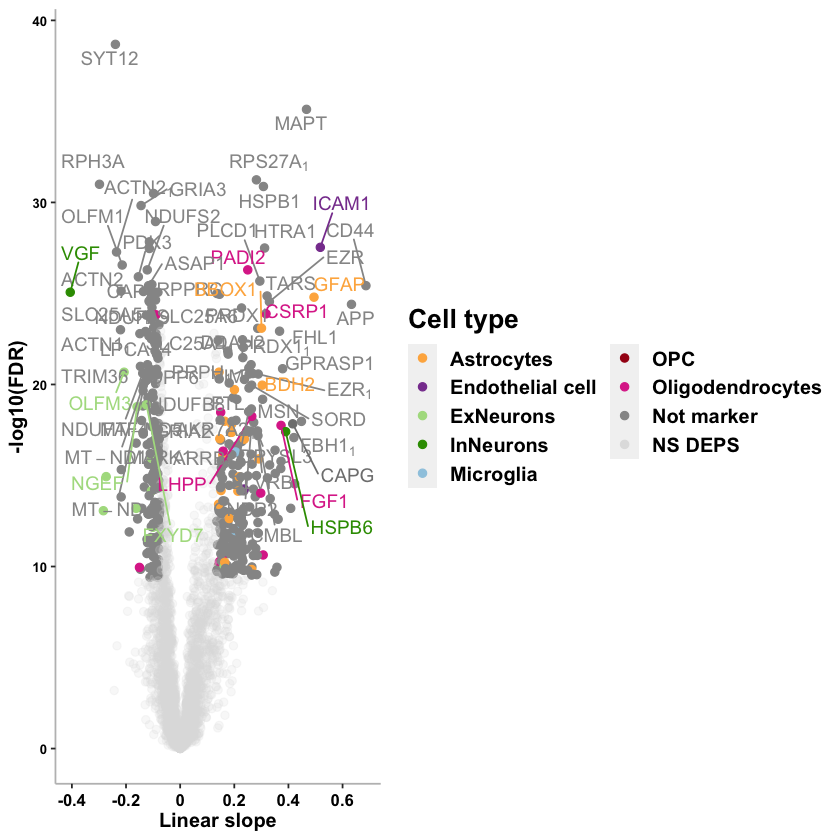

In [102]:
#jpeg("Temp_results/volcano_plot_for_lm_test.jpg")
p2 <- plot_volcano_with_cell_enrich_v2(pathology_related_proteins_lm, 
                                       c(top_down_lm, top_up_lm), 
                                       c(topT_down_lm, topT_up_lm), "Linear slope",
                                       seq(-0.4, 0.6, 0.2), round(seq(-0.4, 0.6, 0.2), 1))
p2
#dev.off()

In [103]:
legend <- get_legend(p1)
p1 <- p1 + theme(legend.position='none')
p2 <- p2 + theme(legend.position='none')

In [104]:
top_row <- plot_grid(p1, p2, align = "h", axis = "b", hjust = 0, vjust = 1.5,
                     rel_widths = c(0.5, 0.5), label_size = 18,
                     labels = c("A", "B"), ncol = 2)

bottom_row <- plot_grid(p, legend, align = "h", axis = "r", hjust = 0, vjust = 1,
                        rel_widths = c(0.5, 0.5), label_size = 18, scale = c(0.9, 1), 
                        labels = c("C", ""),ncol = 2)

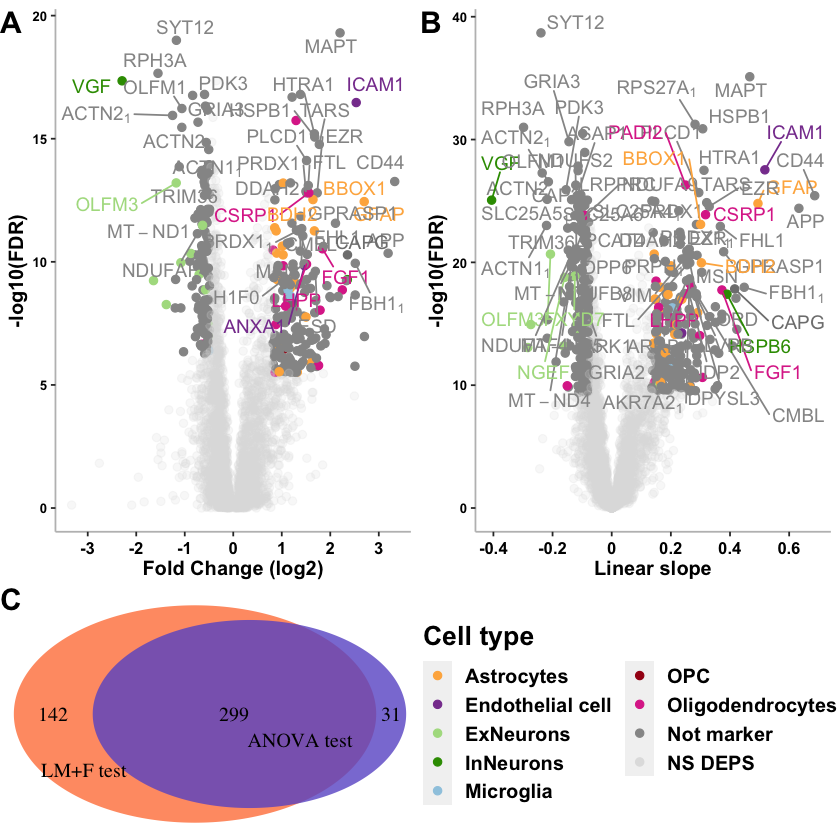

In [105]:
Braak_plot <- plot_grid(top_row, bottom_row, 
                        align = "hv", axis = "r", 
                        rel_heights = c(0.7,0.3),
                        nrow = 2, ncol = 1)
Braak_plot

In [106]:
save_plot("100_plus_plots/proteomics/Braak_stage_related_volcano_AD_ND_move_syserror_names_sub-20221021.pdf", Braak_plot, 
          ncol = 2, base_height = 12, base_width = 6)

In [55]:
#pathology_related_proteins_ANOVA[sig_index, ]

In [32]:
load("early_Braak_proteins.Rdata")

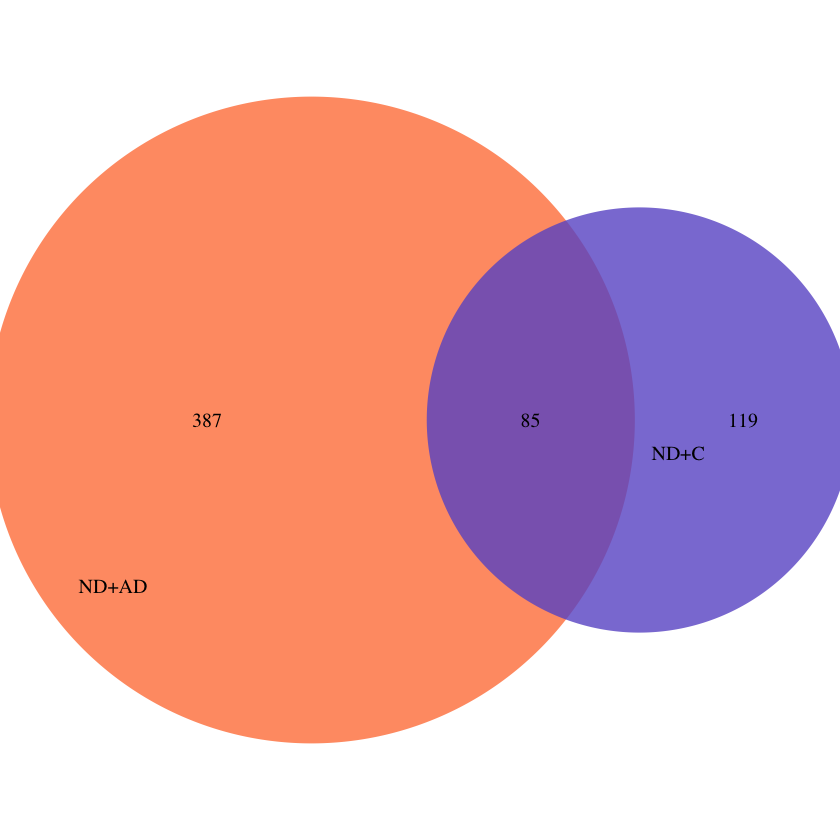

In [33]:
x <- list(early=rownames(early_Braak_proteins), 
          lm=rownames(pathology_related_proteins_ANOVA[sig_index, ]))

#path <- "Temp_results/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = NULL, #imagetype = "png", 
                  fill=c('slateblue', 'sienna1'),
                  category.names=c("ND+C","ND+AD"), margin = -0.01,
                  lwd = 0, alpha = 0.8, cat.dist=c(-0.1, -0.04))
grid.draw(p)

In [74]:
save(pathology_related_proteins_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/pathology_related_proteins_lm.Rdata")

save(cell_type_matrix, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/cell_type_matrix_Braak.Rdata")

save(top_down_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/top_down_lm.Rdata")
save(top_up_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/top_up_lm.Rdata")
save(topT_down_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/topT_down_lm.Rdata")
save(topT_up_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/topT_up_lm.Rdata")

In [67]:
plot_volcano_with_cell_enrich_v2 <- function(data, sig_index, label_index, xlab, x_breaks, x_labels){
    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
    
    labels <- rep(NA, nrow(data_matrix))
    labels[label_index] <- data_matrix[label_index,]$gene
    
    multiple_names_idx <- grep(";", labels)
    labels[multiple_names_idx] <- sapply(labels[multiple_names_idx], function(x){
                                            return(paste(unlist(str_split(x, ";"))[1], "[1]", sep=""))
    })
    data_matrix$labels <- labels
    
    #print(labels)
    
    #print(table(data_matrix$celltype))
    
    data_matrix$celltype <- factor(data_matrix$celltype, 
                                   levels=c("Astrocytes", "Neurons", 
                                            "Oligodendrocytes", 
                                            "NS_celltype", "NS_at_all"))
    
    p <- ggplot(data=data_matrix, 
        aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype, label = labels)) +
    
        #geom_point(data=data_matrix[-sig_index, ],
        #           aes(x=effect_size, y=-log10(adjusted_p_value), col = celltype), 
        #          size = 2, alpha = data_matrix[-sig_index, ]$alpha) +
        
        geom_point(size = 2, alpha = data_matrix$alpha) +
  
        geom_text_repel(size=4, show.legend = FALSE, parse=TRUE, na.rm=TRUE) +
        xlab(xlab) + ylab("-log10(P value) FDR") +
    
        scale_x_continuous(breaks=x_breaks, labels = x_labels) +
    
    
        scale_color_manual(name="Cell type", values = c(Astrocytes, ExNeurons, 
                                                        Oligodendrocytes, 
                                                        No_unique_enrichment, NS_DEPs),
                           labels = c("Astrocytes", 
                                      "Neurons",
                                      "Oligodendrocytes", 
                                      "Not marker", 
                                      "NS DEPS")
                      )+
        guides(color=guide_legend(ncol=2)) +
        #guides(color=FALSE) +
    
        theme(panel.border = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank(),
              
              legend.position = "right",
              legend.direction = "vertical",
              legend.title = element_text(size = 12, color = "black", face = "bold"),
              legend.text = element_text(size = 12, color = "black", face = "bold"),
              axis.title = element_text(size = 12, color = "black", face = "bold"),
              axis.text.x = element_text(size = 10, color = "black", face = "bold", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line = element_line(size = 0.5, linetype = "solid",
                                       colour = "gray")
              #legend.position = "none")
              )
    return(p)
    
}

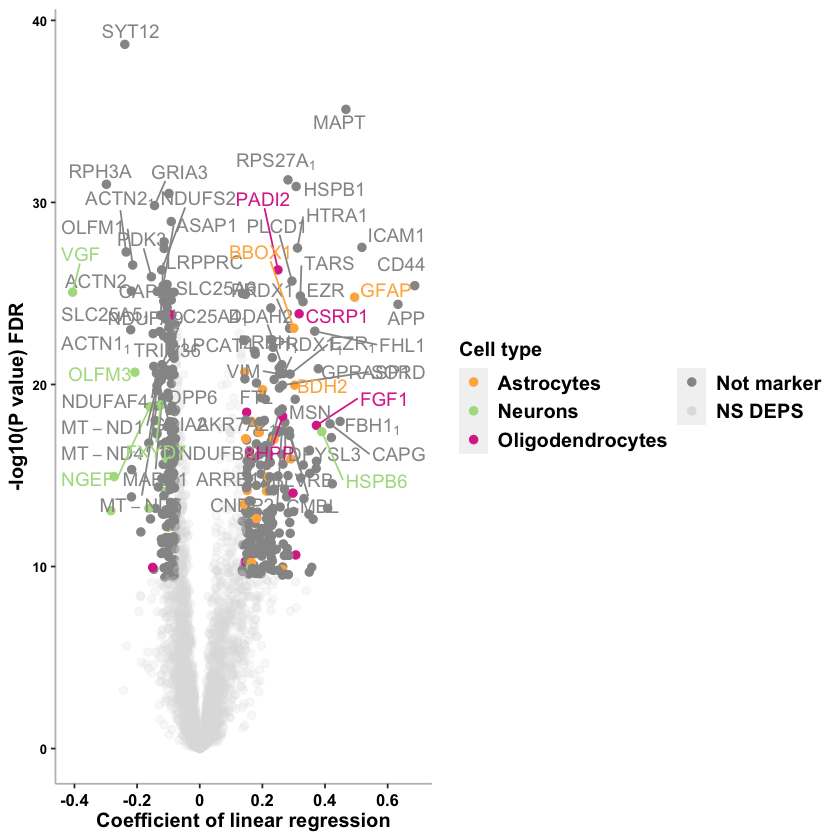

In [68]:
#jpeg("Temp_results/volcano_plot_for_lm_test.jpg")
p2 <- plot_volcano_with_cell_enrich_v2(pathology_related_proteins_lm, 
                                       c(top_down_lm, top_up_lm), 
                                       c(topT_down_lm, topT_up_lm), "Coefficient of linear regression",
                                       seq(-0.4, 0.6, 0.2), round(seq(-0.4, 0.6, 0.2), 1))
p2
#dev.off()

In [72]:
save_plot("100_plus_plots/Braak_stage_related_volcano_AD_ND_move_syserror.pdf", 
          p2, base_height = 8, base_width = 8.5)

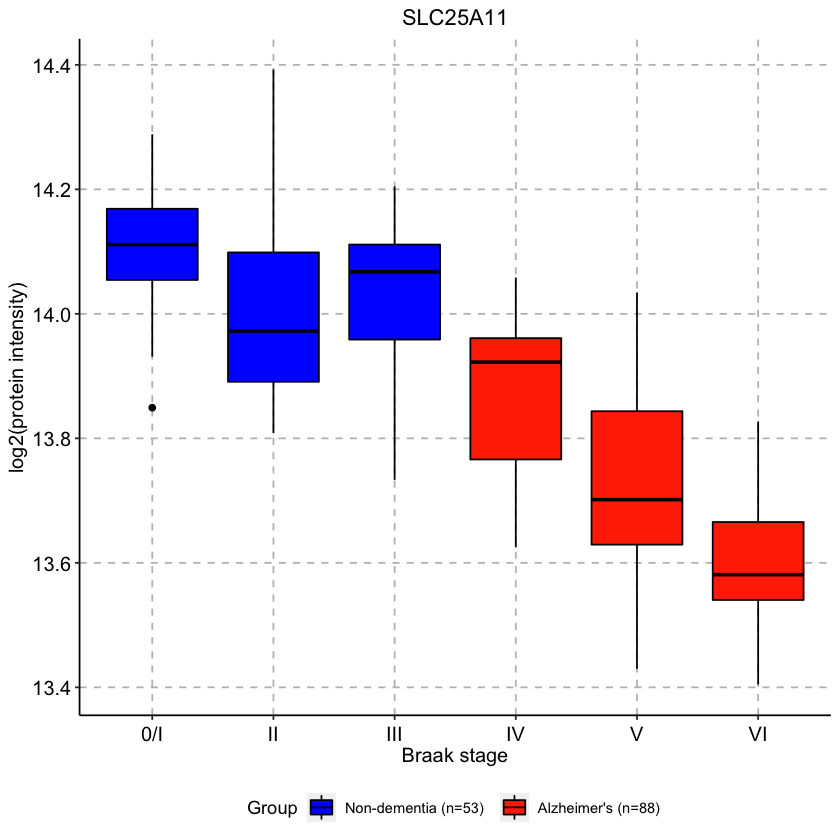

In [91]:
temp_prot <- data.frame(Braak = as.factor(metadata$fBraak),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[sig_index[8],]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))

xlabels <- sort(unique(temp_prot$Braak))
legend_p <- ggplot(subset(temp_prot, group != "CHC"), aes(x = Braak, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("log2(protein intensity)") +
    ggtitle(rownames(protein_intensity_combat)[sig_index[8]]) +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                      values = c(color_ND, color_AD, color_CHC_M), 
                      labels = c("Non-dementia (n=53)", 
                                 "Alzheimer's (n=88)",
                                 "Centenarian (n=49)"))+

    theme(#plot.background = element_rect(),    # Background of the entire plot
      panel.background = element_rect(fill = "white"),   # Background of plotting area
      #panel.border = element_rect(),       # Border around plotting area.
                                           # fill argument should be NA
      legend.position="bottom",

      panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Vertical major grid lines
      panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                            color = "gray"), # Horizontal major grid lines
      panel.grid.minor.x = element_line(), # Vertical minor grid lines
      panel.grid.minor.y = element_line(),  # Vertical major grid lines
    
      plot.title = element_text(hjust = 0.5),
      axis.title.x = element_text(color = "black", size = 12),
      axis.title.y = element_text(color = "black", size = 12),
      
      axis.text.x = element_text(size = 12, color = "black", 
                                 vjust = 0.5, hjust = 0.5),
      axis.text.y = element_text(size = 12, color = "black"),
      
      axis.line = element_line(size = 0.5, linetype = "solid",
                               colour = "black")
     )
legend_p

In [112]:
plot_protective_proteins <- function(index){
    temp_prot <- data.frame(Braak = as.factor(metadata$fBraak),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    xlabels <- sort(unique(temp_prot$Braak))
    p <- ggplot(subset(temp_prot, group != "CHC"), aes(x = Braak, y = intensity))+
        geom_boxplot(aes(fill = group), color = "black") + 
        #stat_boxplot(aes(fill = group), geom ='errorbar') +
        xlab("Braak stage") +
        ylab("Abundance (log2)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
        scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    
        scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC_M))+
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          panel.border = element_rect(color = "black", size = 0.5, fill=NA),       # Border around plotting area.
                                               # fill argument should be NA
            
          legend.position='none',
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5, size = 9),
          axis.title.x = element_text(color = "black", size = 10),
          axis.title.y = element_text(color = "black", size = 10),
          
          axis.text.x = element_text(size = 8, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black"),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                        colour = "black")
         )
    return(p)
    
}

In [113]:
which(rownames(protein_intensity_combat) == "CD44")

[1] 778

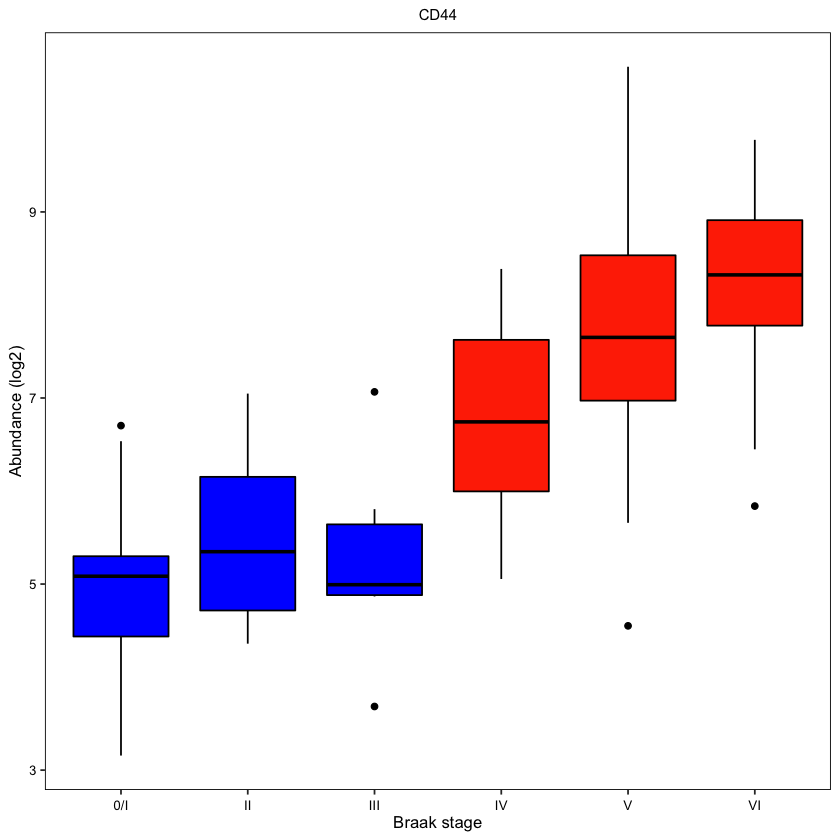

In [114]:
plot_protective_proteins(778)

In [127]:
protein_for_plot

[1] "MAPT"                 "ICAM1"                "VGF"                 
 [4] "CD44"                 "HSPB1"                "HTRA1"               
 [7] "RPH3A"                "TARS"                 "GFAP"                
[10] "PLCD1"                "EZR"                  "RPS27A;UBA52;UBB;UBC"
[13] "CSRP1"                "BBOX1"                "APP"                 
[16] "GPRASP1"

In [128]:
protective_protein_plot <- list()

In [129]:
protein_index <- sapply(protein_for_plot, function(x){
        return(which(rownames(protein_intensity_combat) == x))
    })

In [130]:
protein_index

MAPT                ICAM1                  VGF 
                2719                 3063                  878 
                CD44                HSPB1                HTRA1 
                 778                 2653                 2729 
               RPH3A                 TARS                 GFAP 
                2202                 2915                  635 
               PLCD1                  EZR RPS27A;UBA52;UBB;UBC 
                 646                 1642                 2233 
               CSRP1                BBOX1                  APP 
                2566                 1753                 1230 
             GPRASP1 
                1715

In [131]:
for(i in 1:length(protein_index)){

    p <- plot_protective_proteins(protein_index[i])
    #print(p)
    protective_protein_plot[[i]] <- p
}
protective_protein_plot[[i+1]] <- get_legend(legend_p)

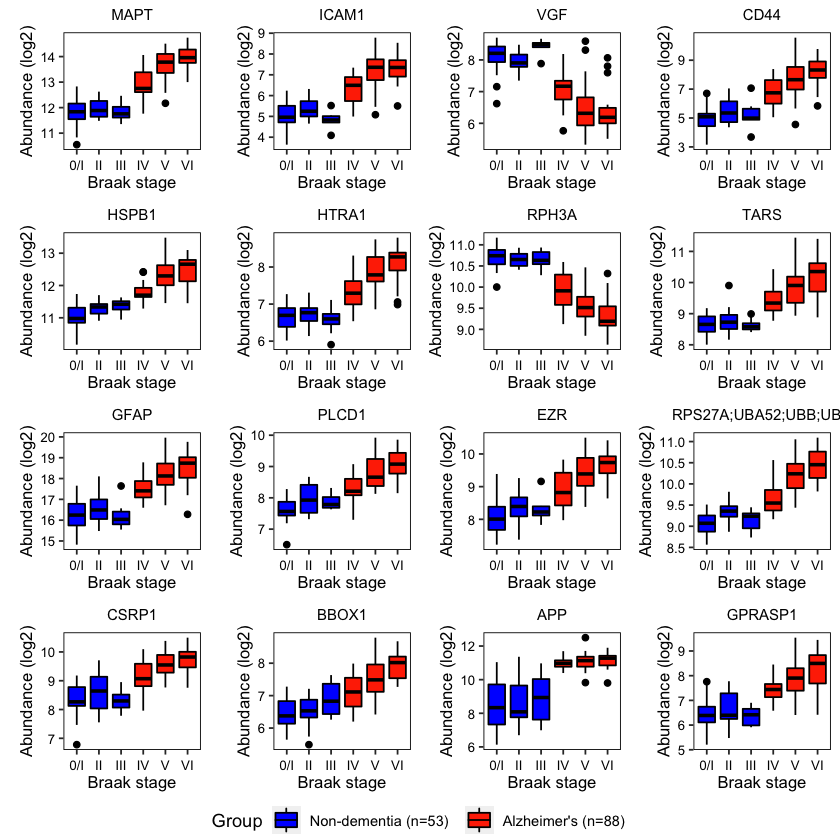

In [133]:
p_for_main_paper <- plot_grid(plotlist = protective_protein_plot[1:16], 
               ncol = 4, align = "vh", axis = "lrtb")

p_with_legend_for_main_paper <- plot_grid(
  p_for_main_paper, protective_protein_plot[[17]],
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(1, 0.05)
)
p_with_legend_for_main_paper

save_plot("100_plus_plots/proteomics/Braak_stage_selected_9_for_main_paper - 20221226.pdf", 
          p_with_legend_for_main_paper, limitsize = FALSE,
          base_height = 8, base_width = 8)